In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold

from sklearn import ensemble
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

process_data = pd.read_csv('housing_midterm_trn.csv')

test_data = pd.read_csv('housing_midterm_test.csv')

# define root mean square error function
def rmse(predictions, targets):
    #return np.sqrt(((predictions - targets) ** 2).mean())
    return np.sqrt(mean_squared_error(predictions, targets))

/home/chris/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


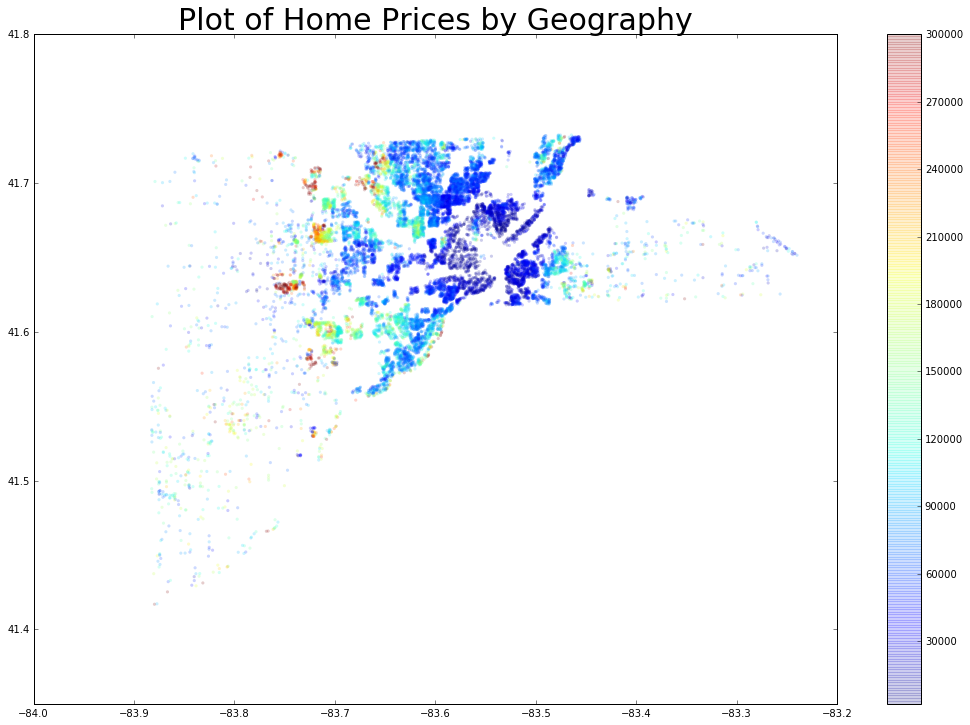

In [2]:
# Importance of Location 

plt.figure(figsize=(18,12))

price = process_data.loc[:,'price'].as_matrix()
price[price>300000]= 300000

plt.scatter(process_data.longitude, process_data.latitude, s=10, c=price, alpha = 0.2, edgecolors='none')

plt.colorbar()
plt.title('Plot of Home Prices by Geography', fontsize=30)

plt.savefig('location_prices.png')

/home/chris/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


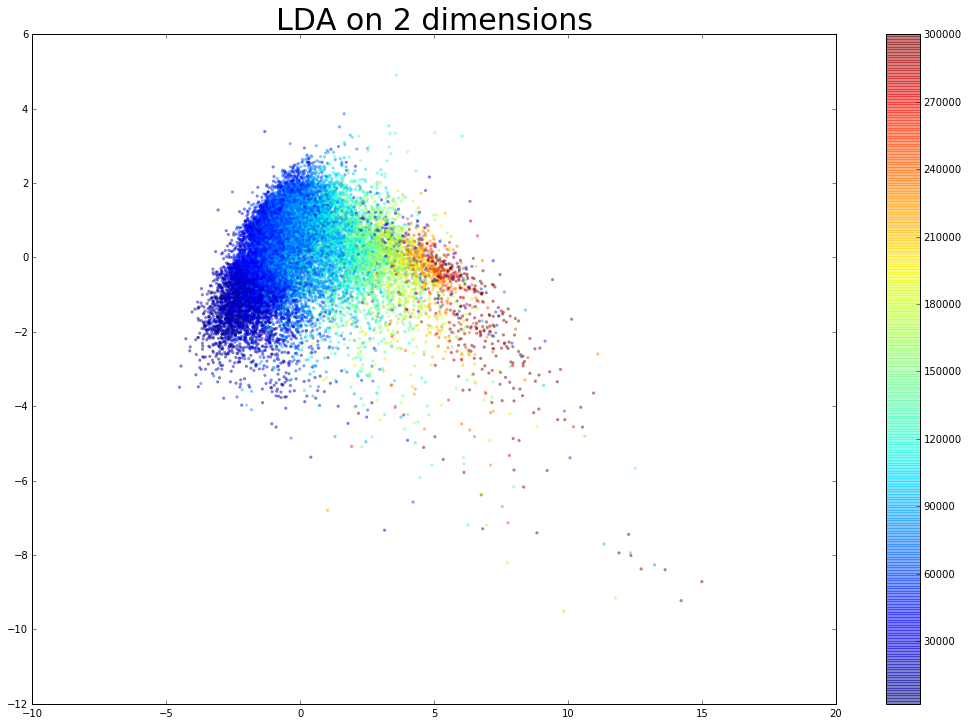

In [3]:
c= ['longitude', 'latitude', 'yrbuilt',
    'TLA', '#beds', '#baths', 'frontage', 
    'lotsize','sale date yymmdd','price']

features= process_data[c]

pca = LinearDiscriminantAnalysis(n_components=2)
X_r = pca.fit(features,price).transform(features)

plt.figure(figsize=(18,12))
plt.scatter(X_r[:,0], X_r[:,1], s=10, c=price, alpha = 0.5, edgecolors='none')
plt.colorbar()

'''
xmin=-5
xmax=5
ymin= -2
ymax=2
plt.axis([xmin,xmax,ymin,ymax])
'''


plt.title('LDA on 2 dimensions', fontsize=30)
plt.savefig('2dimension_LDA_scatterplot.png')

### Processing Data

In [4]:
# Pre process

'''
valuable_c=['longitude', 'latitude', 'yrbuilt', 'stories code', 
            'TLA', 'Wall code', '#beds', '#baths', 'frontage', 
            'garage type code', 'garage sqft', '#rooms', 'lotsize', 'sale date yymmdd','price']
'''

valuable_c=['longitude', 'latitude', 'yrbuilt',
            'TLA', '#beds', '#baths', 'frontage', 
            'lotsize','sale date yymmdd','price']

a_price = .97
h_price = .93
m_price= .75

price_labels = ['low','medium','high','affluent']
btype = [0, process_data.price.quantile(m_price), 
         process_data.price.quantile(h_price),process_data.price.quantile(a_price), process_data.price.max()]

process_data= process_data[valuable_c]
process_data['class_type']=pd.cut(process_data.price, btype, labels=price_labels)

#process_data = process_data[process_data.class_type == 'low']
y = process_data.loc[:,'price']
z = process_data.loc[:,'class_type']
X = process_data.drop(['price','class_type'], axis=1)

### Grid Search 
for optimal paramter values

In [573]:
# Run grid search through Gradient Boosting algorithm to find best parameters 
# (for 1000 estimators case)

from sklearn.grid_search import GridSearchCV
param_grid = {'learning_rate':[.1, .05, .02, .01],
              'max_depth':[4,6],
              'min_samples_leaf': [3,5,9,17],
              'max_features': [1, .3, .1]
              }
est= ensemble.GradientBoostingRegressor(n_estimators = 1000)
gs_cv = GridSearchCV(est,param_grid).fit(X,y)


In [571]:
#Show best params 

gs_cv.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'max_features': 0.3,
 'min_samples_leaf': 3}

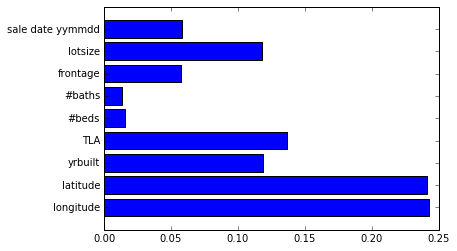

In [657]:
est.fit(X,y)

plt.barh(np.arange(len(X.columns)), est.feature_importances_, align='center')
plt.yticks(np.arange(len(X.columns)), X.columns)

plt.savefig('feature_importances.png')

### Simple Prediction

In [659]:
# Cross Validation

folds = 5

kf = KFold(len(process_data), n_folds=folds, shuffle=True)

for train_index, test_index in kf:
    X_train, X_test = X.ix[train_index], X.ix[test_index]
    y_train, y_test = y[train_index], y[test_index]
    z_train, z_test = z[train_index], z[test_index]
    
    params = {'n_estimators': 1000, 'max_depth': 6,
          'learning_rate': 0.05, 'max_features': 0.3, 'loss': 'ls'}
    
    
    clf = ensemble.GradientBoostingRegressor(**params)

    clf.fit(X_train,y_train)
    
    result = clf.predict(X_test)
    result_error = rmse(y_test, result)
    
    print("RMSE: %.4f" % result_error)

RMSE: 17222.7524
RMSE: 20445.0420
RMSE: 17370.0024
RMSE: 19279.4567
RMSE: 19936.7404


In [647]:
# Predict

sub = pd.read_csv('sample_solution.csv')

process_test_data= pd.DataFrame(test_data)

valuable_c=['longitude', 'latitude', 'yrbuilt',
            'TLA', '#beds', '#baths', 'frontage', 
            'lotsize','sale date yymmdd']

process_test_data= process_test_data[valuable_c]

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X,y)

results = clf.predict(process_test_data)

sub['price'] = results
sub.to_csv('my_submission.csv', header= True, index= False)

advantage of GBRT is it puts less emphasis on outliers compared to general Regression Trees

### Multi Mode 

In [559]:
# Cross Validation

folds = 5

kf = KFold(len(process_data), n_folds=folds, shuffle=True)

print btype

for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    z_train, z_test = z[train_index], z[test_index]
    
    params = {'n_estimators': 700, 'max_depth': 10,
          'learning_rate': 0.05, 'max_features': 0.3, 'loss': 'ls'}
    
    cls = tree.DecisionTreeClassifier(max_depth=9, max_features = 9)
    cls.fit(X_train, z_train)
    
    
    z_predict = cls.predict(X_test)
    
    print accuracy_score(z_test, z_predict)
    #print "z_predict shape: %.f" % np.shape(z_predict)
    
    result_error_bin = []
    for label in price_labels:
        
        #print label
        
        X_train_bin = X_train[np.where(z_train == label)]
        y_train_bin = y_train[np.where(z_train == label)]
        
        clf = ensemble.GradientBoostingRegressor(**params)
        #clf = LinearDiscriminantAnalysis(n_components=3)
        clf.fit(X_train_bin,y_train_bin)
        
        X_test_bin = X_test[np.where(z_predict == label)]
        y_test_bin = y_test[np.where(z_predict == label)]

        result_error = rmse(y_test_bin, clf.predict(X_test_bin))
        result_error_bin.append((len(X_train_bin)/ float(len(X_train)))*result_error)
       
    print("RMSE: %.4f" % np.sum(result_error_bin))

[0, 97267.0, 169000.0, 225000.0, 875000]
0.872298624754
RMSE: 19544.0504
0.873772102161
RMSE: 17772.8295
0.873986735446
RMSE: 18735.4664
0.881110292311
RMSE: 17899.9513
0.880127732744
RMSE: 17621.5938


In [563]:
# My attempt at prediction     
    
    X_train= X
    y_train= y
    z_train= z
    
    X_test_bin = test_data
    
    params = {'n_estimators': 700, 'max_depth': 10,
          'learning_rate': 0.05, 'max_features': 0.3, 'loss': 'ls'}
    
    cls = tree.DecisionTreeClassifier(max_depth=9, max_features = 9)
    cls.fit(X_train, z_train)
    
    
    z_predict = cls.predict(X_test)
    
    print accuracy_score(z_test, z_predict)
    #print "z_predict shape: %.f" % np.shape(z_predict)
    
    result_error_bin = []
    for label in price_labels:
        
        #print label
        
        X_train_bin = X_train[np.where(z_train == label)]
        y_train_bin = y_train[np.where(z_train == label)]
        
        clf = ensemble.GradientBoostingRegressor(**params)
        #clf = LinearDiscriminantAnalysis(n_components=3)
        clf.fit(X_train_bin,y_train_bin)
        
        X_test_bin = X_test[np.where(z_predict == label)]
        y_test_bin = y_test[np.where(z_predict == label)]

        print np.size(clf.predict(X_test_bin))
        

0.908867600098
3027
768
156
120
